# Preprocessing Module
The primary purpose of this module is to gather, preprocess, split all of the data that will be used for our model.

# Import Libraries

In [1]:
# Basic Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

#Set directory
current_directory_path = r"C:\\Users\\atr8e/OneDrive/Documents/GitHub/Big-Data-Systems/Team 6/"
os.chdir(current_directory_path)

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image Libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import lime
from lime import lime_image
import cv2  # Import cv2 for image processing
from skimage.transform import resize
import pickle

# Functions
Below you can find three for conducting the preprocessing:
- **set_limiting_factor()**: To assure balanced data in the preprocessed dataset, you can use this function to feed in the directory paths to the datasets to return the number of images in the shortest dataset. This allows you to select the number of images you want to use from each dataset without having to pull in the all of images.
- **preprocess_images()**:
  - Takes the path to the dataset of interest, the label you want for the dataset, and the limiting factor for the number of images to take.
  - Preprocesses the images by resizing.
  - Produces a sample of newly preprocessed images.
  - Splits them into train, validation, and test at an 80%/10%/10% split.
  - Returns the images and their respective labels.
- **preprocessing_images_bulk()**
  - Takes a list of paths to multiple datasets, labels for each of them, and the limiting factor.
  - Preprocesses each dataset using preprocess_images().
  - Combines the split datasets.
  - Returns the split datasets.

In [2]:
def set_limiting_factor(dataset_paths):
    '''Pass a list of directory paths to return the length of the shortest one'''
    limiting_factor = min(len(os.listdir(dataset)) for dataset in dataset_paths)
    print(f'Limiting Factor of Datasets: {limiting_factor}')
    return limiting_factor

In [3]:
# Function to preprocess the images in a given directory
def preprocess_images(image_dir, label, limiting_factor=100):
    images = []
    labels = []
    count = 0
    
    for filename in os.listdir(image_dir):
        if count >= limiting_factor:
            break  # Exit the loop if we've processed enough images
        
        if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path)
            if image.mode != "L":
                image = image.convert("L")    # Convert grayscale to grayscale
            image = image.resize((256, 256))  # Resize images to 256x256 pixels
            
            # Normalize pixel values to [0, 1]
            #image = np.array(image) / 255.0
            #min_val = np.min(image_array)
            #max_val = np.max(image_array)
            #image_array_normalized = (image_array - min_val) / (max_val - min_val + 1e-9)  # Add small value to avoid division by zero
            
            images.append(image)
            labels.append(label)
            count += 1
            if (count % round((limiting_factor/4)) == 0) | (count == limiting_factor):
                print(f'Processed: {count}/{limiting_factor} images for {image_dir[88:]}')
    
    # Display sample images from each class
    plt.figure(figsize=(12, 5))
    for i in range(5):
        plt.subplot(3, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"{image_dir[81:]}")
        plt.axis("off")
    plt.show()
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Split the data into train/validation/test split of 80/10/10
    train_images, test_images, \
    train_labels, test_labels \
    = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
    
    validation_images, test_images, \
    validation_labels, test_labels \
    = train_test_split(test_images, test_labels, test_size=0.5, random_state=42, stratify=test_labels)
        
    return train_images, validation_images, test_images, \
           train_labels, validation_labels, test_labels

In [4]:
# Function to preprocess images from multiple directories with respective labels
def preprocess_images_bulk(image_dir_list, label_list, limiting_factor=100):
    train_images = []
    validation_images = []
    test_images = []
    train_labels = []
    validation_labels = []
    test_labels = []
    
    for image_dir, label in zip(image_dir_list, label_list):
        train_images_i, validation_images_i, test_images_i, \
        train_labels_i, validation_labels_i, test_labels_i \
        = preprocess_images(image_dir, label, limiting_factor=limiting_factor)
        
        # Append images from current directory to the list
        train_images.extend(train_images_i) 
        validation_images.extend(validation_images_i)
        test_images.extend(test_images_i)
        
        # Append labels from current directory to the list
        train_labels.extend(train_labels_i)
        validation_labels.extend(validation_labels_i)
        test_labels.extend(test_labels_i)
        
    return train_images, validation_images, test_images, \
           train_labels, validation_labels, test_labels

# Datasets

In [5]:
# Set paths to the datasets
dataset_dir = r"C:\\Users\\atr8e/OneDrive/Documents/GitHub/Big-Data-Systems/Team 6/full_data/imgs/train/"

# Classes
c0_dir = os.path.join(dataset_dir, "c0")
c1_dir = os.path.join(dataset_dir, "c1")
c2_dir = os.path.join(dataset_dir, "c2")
c3_dir = os.path.join(dataset_dir, "c3")
c4_dir = os.path.join(dataset_dir, "c4")
c5_dir = os.path.join(dataset_dir, "c5")
c6_dir = os.path.join(dataset_dir, "c6")
c7_dir = os.path.join(dataset_dir, "c7")
c8_dir = os.path.join(dataset_dir, "c8")
c9_dir = os.path.join(dataset_dir, "c9")

## List the paths, set the labels, and set the limiting factor for each respective dataset of interest

In [6]:
# Main Model Dataset
class_paths = [c0_dir, c1_dir, c2_dir, c3_dir, c4_dir, c5_dir, c6_dir, c7_dir, c8_dir, c9_dir]
class_labels = [0,1,2,3,4,5,6,7,8,9]
#class_labels = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
class_lf = set_limiting_factor(class_paths)
model_inputs = class_paths, class_labels, class_lf

Limiting Factor of Datasets: 1911


## Process, Split, and Save the Ensemble Main Model Datasets

Processed: 478/1911 images for /train/c0
Processed: 956/1911 images for /train/c0
Processed: 1434/1911 images for /train/c0
Processed: 1911/1911 images for /train/c0


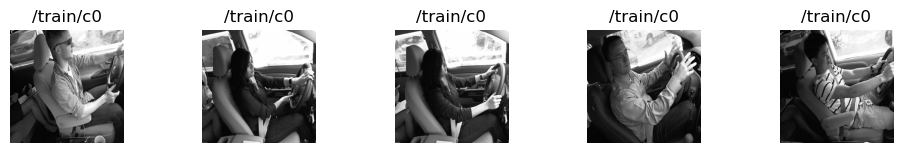

Processed: 478/1911 images for /train/c1
Processed: 956/1911 images for /train/c1
Processed: 1434/1911 images for /train/c1
Processed: 1911/1911 images for /train/c1


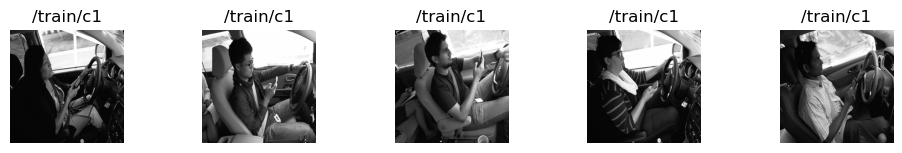

Processed: 478/1911 images for /train/c2
Processed: 956/1911 images for /train/c2
Processed: 1434/1911 images for /train/c2
Processed: 1911/1911 images for /train/c2


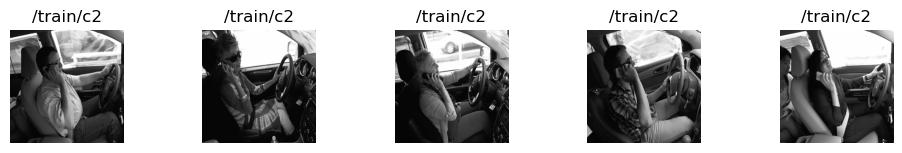

Processed: 478/1911 images for /train/c3
Processed: 956/1911 images for /train/c3
Processed: 1434/1911 images for /train/c3
Processed: 1911/1911 images for /train/c3


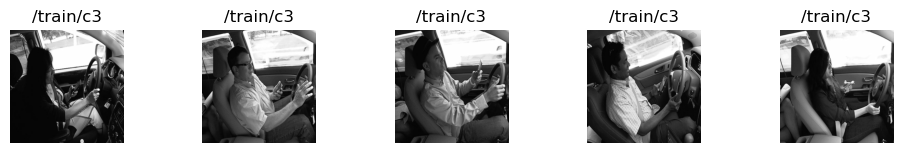

Processed: 478/1911 images for /train/c4
Processed: 956/1911 images for /train/c4
Processed: 1434/1911 images for /train/c4
Processed: 1911/1911 images for /train/c4


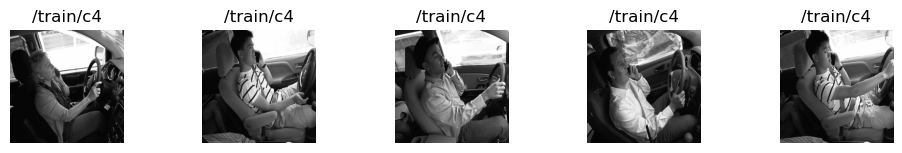

Processed: 478/1911 images for /train/c5
Processed: 956/1911 images for /train/c5
Processed: 1434/1911 images for /train/c5
Processed: 1911/1911 images for /train/c5


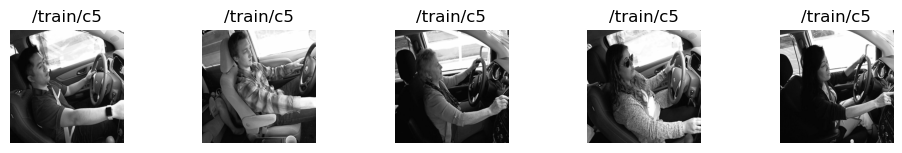

Processed: 478/1911 images for /train/c6
Processed: 956/1911 images for /train/c6
Processed: 1434/1911 images for /train/c6
Processed: 1911/1911 images for /train/c6


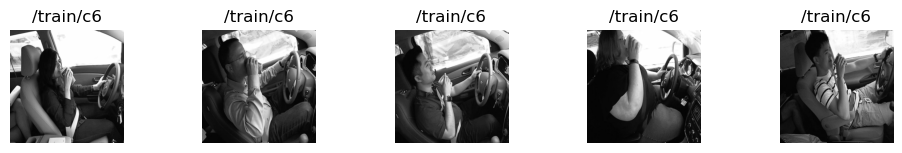

Processed: 478/1911 images for /train/c7
Processed: 956/1911 images for /train/c7
Processed: 1434/1911 images for /train/c7
Processed: 1911/1911 images for /train/c7


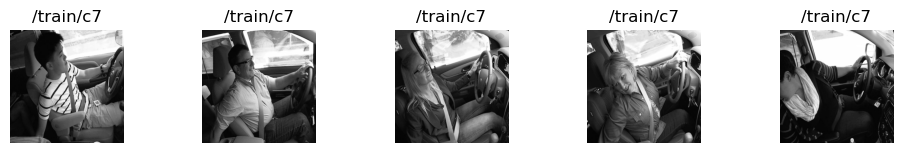

Processed: 478/1911 images for /train/c8
Processed: 956/1911 images for /train/c8
Processed: 1434/1911 images for /train/c8
Processed: 1911/1911 images for /train/c8


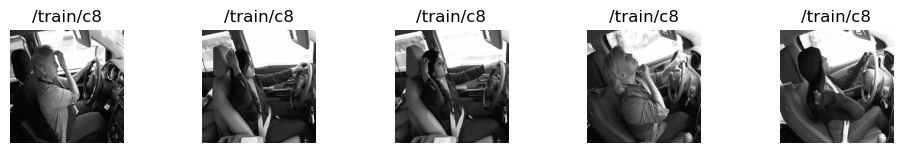

Processed: 478/1911 images for /train/c9
Processed: 956/1911 images for /train/c9
Processed: 1434/1911 images for /train/c9
Processed: 1911/1911 images for /train/c9


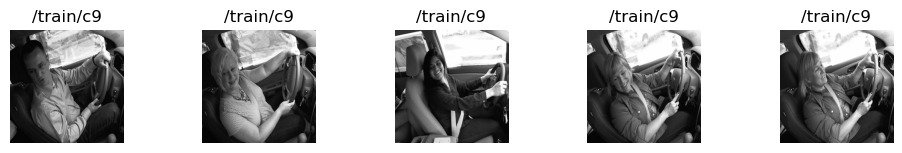

In [7]:
# Process and Split
train_images, val_images, test_images, \
train_labels, val_labels, test_labels = preprocess_images_bulk(*model_inputs)

# Save Training Data
file_path = 'Models_and_Datasets/training_data.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((train_images, train_labels), file)
    
# Save Validation Data
file_path = 'Models_and_Datasets/val_data.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((val_images, val_labels), file)
    
# Save Testing Data
file_path = 'Models_and_Datasets/test_data.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((test_images, test_labels), file)

In [8]:
## Load the dataset from the file
#with open(file_path, 'rb') as file:
#    test_images, test_labels = pickle.load(file)
#
#test_images

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [10]:
def create_cnn_model(input_shape):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Dense (fully connected) layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))  # Output layer with 10 classes ( 10 classes for distraction types)
    
    return model

# Input images are resized to 256x256 pixels and have 3 color channels (RGB)
input_shape = (256, 256, 1)
cnn_model = create_cnn_model(input_shape)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# Display the model architecture
cnn_model.summary()

C:\Users\atr8e\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      14,745,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,802,058 (56.47 MB)

 Trainable params: 14,802,058 (56.47 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Convert lists to numpy arrays
train_images_array = np.array(train_images)
val_images_array = np.array(val_images)
test_images_array = np.array(test_images)

train_labels_array = np.array(train_labels)
val_labels_array = np.array(val_labels)
test_labels_array = np.array(test_labels)

# Normalize pixel values to [0, 1]
train_images_normalized = train_images_array / 255.0
val_images_normalized = val_images_array / 255.0
test_images_normalized = test_images_array / 255.0

# Verify shapes after conversion
print(train_images_normalized.shape)
print(train_labels_array.shape)
print(val_images_normalized.shape)
print(val_labels_array.shape)

(15280, 256, 256)
(15280,)
(1910, 256, 256)
(1910,)


In [12]:
# Train the model
cnn_model.fit(train_images_array, train_labels_array, epochs=5, validation_data=(val_images_array, val_labels_array))

Epoch 1/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 253s 520ms/step - accuracy: 0.6574 - loss: 34.7738 - val_accuracy: 0.8445 - val_loss: 1.0276
Epoch 2/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 266s 556ms/step - accuracy: 0.9726 - loss: 0.0969 - val_accuracy: 0.9733 - val_loss: 0.1081
Epoch 3/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 292s 612ms/step - accuracy: 0.9877 - loss: 0.0483 - val_accuracy: 0.9649 - val_loss: 0.1254
Epoch 4/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 288s 602ms/step - accuracy: 0.9875 - loss: 0.0423 - val_accuracy: 0.9822 - val_loss: 0.0975
Epoch 5/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 287s 600ms/step - accuracy: 0.9958 - loss: 0.0142 - val_accuracy: 0.9859 - val_loss: 0.0655


In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_images_array, test_labels_array)
print(f"Test Accuracy: {test_accuracy}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9773 - loss: 0.0925
Test Accuracy: 0.9817708134651184


In [16]:
# Specify the file path where you want to save the model
model_save_path = r"C:\\Users\\atr8e/OneDrive/Documents/GitHub/Big-Data-Systems/Team 6/Models_and_Datasets/distracted_drivers_cnn_model.h5"

# Save the trained model to the specified file path
cnn_model.save(model_save_path)

print("Model saved successfully at:", model_save_path)

Model saved successfully at: C:\\Users\\atr8e/OneDrive/Documents/GitHub/Big-Data-Systems/Team 6/Models_and_Datasets/distracted_drivers_cnn_model.h5


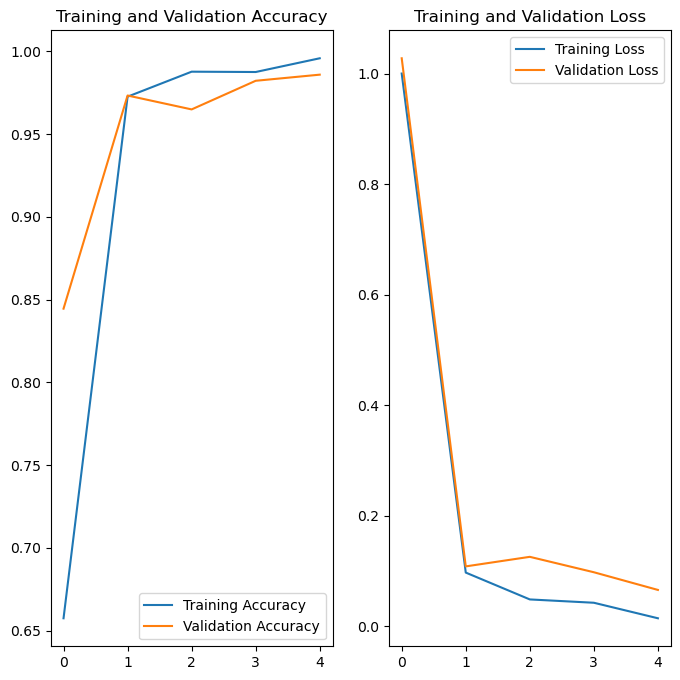

In [21]:
epochs=5

# Visualize the training results
acc = [0.6574, 0.9726, 0.9877, 0.9875, 0.9958]
val_acc = [0.8445, 0.9733, 0.9649, 0.9822, 0.9859]

loss = [1.0000, 0.0969, 0.0483, 0.0423, 0.0142]
val_loss = [1.0276, 0.1081, 0.1254, 0.0975, 0.0655]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()